In [ ]:
pip install selenium

# Extracción de los ganadores a mejor pelicula internacional 

In [3]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
import pandas as pd
driver = webdriver.Chrome()

In [109]:
driver.get("https://es.wikipedia.org/wiki/Anexo:Ganadores_y_nominados_del_%C3%93scar_a_la_mejor_pel%C3%ADcula_internacional#1947-1949")

# Inicializar la lista para las tablas
tables = []

# Generar los XPaths y recoger las tablas
for i in range(3, 11):  # Ajustado a 10 para incluir la tabla 9
    xpath = f"/html/body/div[2]/div/div[3]/main/div[3]/div[3]/div[1]/table[{i}]"
    table = driver.find_element(By.XPATH, xpath)
    tables.append(table)

# Inicializar una lista para almacenar los datos
oscars_data = []

In [ ]:
for table in tables:
    rows = table.find_elements(By.TAG_NAME, 'tr')
    inicio = 1
    fin = len(rows) 
    print(fin)
    salto = 5

    for i in range(inicio, fin, salto):
        cells = rows[i].find_elements(By.TAG_NAME, 'td')
        print(len(cells))
        año = cells[0].find_element(By.TAG_NAME, 'a').text
        titulo = cells[1].text
        
        link = cells[1].find_element(By.TAG_NAME, 'a').get_attribute('href')
        titulo_original = cells[2].text
        pais = cells[3].text
        director = cells[4].text
        idioma = cells[5].text
        
        print(titulo)
        
        oscars_data.append([año, titulo, titulo_original, pais, director, idioma, link])
        

# Crear un DataFrame con los datos
df = pd.DataFrame(oscars_data, columns=['Año', 'Título', 'Título original', 'País', 'Director', 'Idioma', 'Link'])



In [114]:
# pasar a csv
df.to_csv('oscars_2.csv', index=False)

# Extracción de sinopsis de las peliculas

In [ ]:
Ruta = 'oscars_2.csv'
df = pd.read_csv(Ruta)
links = df['Link']
links

In [ ]:
def get_paragraph_text(url):
    """Function to retrieve the text of the first <p> element following the first <h2>."""
    driver.get(url)
    try:
        # Adjusted XPath to use a more robust relative path approach
        p = driver.find_element(By.XPATH, "/html/body/div[2]/div/div[3]/main/div[3]/div[3]/div[1]/h2[1]/following-sibling::p[1]")
        print(url)
        print(p.text)
        return p.text
    except NoSuchElementException:
        return None  # Return None if no paragraph is found

# Apply the function to each URL in the 'Link' column of the DataFrame
df['Paragraph_Text'] = df['Link'].apply(get_paragraph_text)


In [ ]:
df

# Limpieza de Datos - general

In [121]:
df.isnull().sum()

Año                0
Título             0
Título original    0
País               0
Director           0
Idioma             0
Link               0
Paragraph_Text     6
dtype: int64

Se llenan las sinopsis no encontradas con datos de https://www.filmaffinity.com/

1. Data frame con las sinopsis de las peliculas no encontradas

# TF-IDF: Representar las sinopsis

Recordemos que:

- **TF (Term Frequency)** mide la frecuencia con la que aparece una palabra en un documento. Si una palabra aparece muchas veces en un documento, se considera importante dentro de ese documento.
- **IDF (Inverse Document Frequency**) disminuye el peso de las palabras que aparecen muy frecuentemente en la colección de documentos y aumenta el peso de las palabras que son raras.

## Limpieza de datos

In [1]:
import pandas as pd
df = pd.read_csv('oscars_sfinal.csv', sep=';')

In [2]:
df = df.rename(columns={'Paragraph_Text': 'Sinopsis'})

In [3]:
import spacy
from unidecode import unidecode

# Carga el modelo en español de spaCy
nlp = spacy.load('es_core_news_sm')

# Lista de palabras adicionales para considerar como stopwords
stop_words_extra = ['algún', 'alguna', 'algunos', 'algunas', 'aquel', 'aquella', 'aquellos', 'aquellas', 'mío', 'mía', 'él']

# Añade las palabras adicionales a las stopwords de spaCy
for stopword in stop_words_extra:
    # Usamos unidecode para normalizar el texto y evitar errores por caracteres especiales
    normalized_stopword = unidecode(stopword)
    nlp.Defaults.stop_words.add(normalized_stopword)

def lematizar_texto(texto):
    # Procesa el texto con spaCy
    doc = nlp(texto)
    # Extrae los lemas de cada token en el documento
    lemas = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop and not unidecode(token.lemma_) in [unidecode(sw) for sw in stop_words_extra]]
    # Reconstruye el texto procesado
    texto_procesado = ' '.join(lemas)
    return texto_procesado

df['sinopsis_limpia'] = df['Sinopsis'].apply(lematizar_texto)


## Calibrar vectorizador

### PCA

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np

# Configurar el vectorizador TF-IDF con parámetros específicos
vectores = TfidfVectorizer(max_df=0.8, max_features=80, stop_words=['él', 'película', 'hacer', 'cine', 'cuyo'])

# Aplicar el vectorizador a tus datos y convertir la matriz a una matriz densa
matriz_tfidf = vectores.fit_transform(df['sinopsis_limpia']).toarray()

# Obtener nombres de características
nombres = vectores.get_feature_names_out()

# Ajustar PCA a la matriz TF-IDF
pca = PCA(n_components=4).fit(matriz_tfidf)

# Definir función para mostrar los tópicos y las palabras clave asociadas
def display_topics(feature_names, model, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Tópico %d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 8

display_topics(nombres, pca, no_top_words)



Tópico 0:
historia comenzar celebrar amor hombre momento desarrollar regresar
Tópico 1:
nazi mundial guerra historia judío vida alemania desarrollar
Tópico 2:
grupo encontrar llamado amante matrimonio volver soldado lugar
Tópico 3:
vida comenzar celebrar vivir trabajo padre año quedar


### NMF

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

miramos el numero de palabras totales

In [41]:
# numero de palabras en toda la columna de sinopsis_limpia
df['sinopsis_limpia'].str.split().str.len().sum()

2944

In [55]:
vectorizador_tfidf = TfidfVectorizer(max_df=0.90,min_df=0.1 ,max_features=1000)
matriz_tfidf = vectorizador_tfidf.fit_transform(df['sinopsis_limpia'])

- max_df: Ignora los términos que tienen una frecuencia de documento más alta que el valor dado.
- min_df: Ignora los términos que tienen una frecuencia de documento más baja que el valor dado.
- max_features: Establece el número máximo de términos que serán considerados, los cuales son los más frecuentes.

(índice del documento, indice del término) ->  Peso TF-IDF para el término correspondiente en ese documento.


In [58]:
similitud_coseno = cosine_similarity(matriz_tfidf, matriz_tfidf)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [8]:
# Configurar el vectorizador TF-IDF con parámetros específicos
vectores = TfidfVectorizer(max_df=0.8, max_features=80, stop_words=['él', 'película','hacer', 'cine', 'cuyo'])
tfslimpio = vectores.fit_transform(df['sinopsis_limpia']) 
nombreslimpio = vectores.get_feature_names_out()


# Configurar y aplicar el modelo NMF a la matriz TF-IDF
nmflimpio = NMF(n_components=4, random_state=1, l1_ratio=.5, init='nndsvd').fit(tfslimpio)

# Función para mostrar los tópicos y las palabras clave asociadas
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Tópico %d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 7


display_topics(nmflimpio, nombreslimpio, no_top_words)


Tópico 0:
padre madre año vivir casa pequeño hijo
Tópico 1:
historia comenzar celebrar amor desarrollar ciudad hombre
Tópico 2:
nazi mundial guerra judío vida alemania concentración
Tópico 3:
grupo amigo encontrar matrimonio trabajo llamado comenzar


/Users/paulatorres/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/paulatorres/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/paulatorres/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


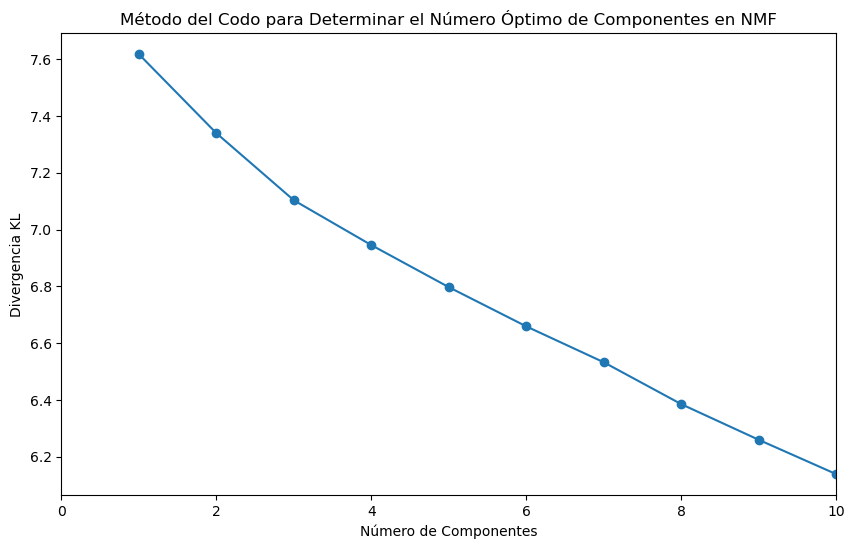

In [151]:
import numpy as np
import matplotlib.pyplot as plt

# Inertia es una medida de la calidad del clustering
inertia = []
# Prueba diferentes números de componentes
num_componentes = range(1, 11)

for k in num_componentes:
    # Entrenar el modelo NMF con el número de componentes actual
    nmf = NMF(n_components=k, random_state=1, l1_ratio=.5, init='nndsvd')
    nmf.fit(tfslimpio)
    # Añadir la inercia a la lista
    inertia.append(nmf.reconstruction_err_)

# Graficar la inercia en función del número de componentes
plt.figure(figsize=(10, 6))
plt.plot(num_componentes, inertia, marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Divergencia KL')
plt.xlim(0, max(num_componentes))
plt.title('Método del Codo para Determinar el Número Óptimo de Componentes en NMF')
plt.show()


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text  # Asegúrate de instalar este paquete

# Suponiendo que cargas_topico, df_filtered, y otras variables necesarias ya están definidas

# Coordenadas para el gráfico
coordenadas_x = cargas_topico[:, 0]  # Utilizamos la primera componente
coordenadas_y = cargas_topico[:, 1]  # Utilizamos la segunda componente

# Configurar los límites del eje x e y
limite = 0.3

# Graficar las cargas de tópicos para los documentos
plt.figure(figsize=(15, 10))
scatter = sns.scatterplot(x=coordenadas_x, y=coordenadas_y, alpha=0.5)  # alpha para transparencia de puntos
plt.title('Similitud entre películas basada en tópicos de NMF (Componente 0)')
plt.xlabel('Componente 0')
plt.ylabel('Componente 1')

# Ajustar los límites del eje x e y manualmente para hacer zoom
plt.xlim(0, limite)
plt.ylim(0, limite)

# Crear una lista para guardar las etiquetas de texto y evitar la superposición
texts = []
for i, (nombre, año) in enumerate(zip(df_filtered['Título'], df_filtered['Año'])):
    if 0 <= coordenadas_x[i] <= limite and 0 <= coordenadas_y[i] <= limite:
        texts.append(plt.text(coordenadas_x[i], coordenadas_y[i], f'{nombre} ({año})', fontsize=9))

# Usar adjustText para optimizar la posición de las etiquetas
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

# Mostrar o guardar la figura
plt.tight_layout()  # Ajustar el layout antes de guardar
plt.savefig('output.png', dpi=300)  # Guardar la figura con alta resolución
plt.show()  # Descomenta esta línea si solo deseas mostrar el gráfico


ModuleNotFoundError: No module named 'adjustText'

In [ ]:
coordenadas_x = cargas_topico[:, 0]
coordenadas_y = cargas_topico[:, 1]

# agregar coodenadas a los tópicos
plt.figure(figsize=(10, 6))
plt.scatter(coordenadas_x, coordenadas_y, color='blue', s=100)
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.title('Distribución de Tópicos en el Espacio de Componentes Principales')
plt.grid(True)
plt.show()
